In [1]:
import csv
import ast
import math
import random
import matplotlib.pyplot as plt

In [16]:
#Read CSV
def read_data(filename):
    events = []
    with open(filename, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            location = ast.literal_eval(row['location'])
            event = {
                'index': int(row['Event Count']),
                'lat': float(location['latitude']),
                'lon': float(location['longitude']),
                'duration': float(row['Event duration'])
            }
            events.append(event)
    return events

In [17]:
#Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

In [18]:
#Assign events to closest centroid
def assign_clusters(centroids, events):
    clusters = [[] for _ in centroids]
    for event in events:
        distances = [haversine(event['lat'], event['lon'], c['lat'], c['lon']) for c in centroids]
        cluster_idx = distances.index(min(distances))
        clusters[cluster_idx].append(event)
    return clusters

In [19]:
# Update centroids
def update_centroids(clusters):
    centroids = []
    for cluster in clusters:
        if cluster:
            avg_lat = sum(e['lat'] for e in cluster) / len(cluster)
            avg_lon = sum(e['lon'] for e in cluster) / len(cluster)
            centroids.append({'lat': avg_lat, 'lon': avg_lon})
    return centroids

In [6]:
# Step 5: SSE calculation
def compute_sse(clusters, centroids):
    sse = 0
    for i, cluster in enumerate(clusters):
        for e in cluster:
            dist = haversine(e['lat'], e['lon'], centroids[i]['lat'], centroids[i]['lon'])
            sse += dist ** 2
    return sse

In [20]:
# K-Means algorithm
def k_means(events, k, max_iter=100):
    centroids = random.sample(events, k)
    centroids = [{'lat': e['lat'], 'lon': e['lon']} for e in centroids]

    for _ in range(max_iter):
        clusters = assign_clusters(centroids, events)
        new_centroids = update_centroids(clusters)
        if new_centroids == centroids:
            break
        centroids = new_centroids
    return clusters, centroids

In [21]:
# Elbow Method
def find_optimal_k(events, k_range=(2, 10)):
    sse_list = []
    for k in range(k_range[0], k_range[1] + 1):
        clusters, centroids = k_means(events, k)
        sse = compute_sse(clusters, centroids)
        sse_list.append((k, sse))
        print(f"k = {k}, SSE = {sse:.2f}")
    return sse_list

In [22]:
# Cluster statistics
def summarize_clusters(clusters):
    for i, cluster in enumerate(clusters):
        durations = [e['duration'] for e in cluster]
        avg = sum(durations) / len(durations)
        max_d = max(durations)
        min_d = min(durations)
        print(f"\nCluster {i+1}:")
        print(f" - Event Count: {len(cluster)}")
        print(f" - Avg Duration: {avg:.2f}")
        print(f" - Max Duration: {max_d:.2f}")
        print(f" - Min Duration: {min_d:.2f}")

In [23]:
# Plot clusters
def plot_clusters(clusters):
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta', 'black', 'yellow', 'brown']
    for i, cluster in enumerate(clusters):
        lats = [e['lat'] for e in cluster]
        lons = [e['lon'] for e in cluster]
        plt.scatter(lons, lats, color=colors[i % len(colors)], label=f"Cluster {i+1}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Event Clusters")
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
# Plots for Visualisation
def plot_event_counts(clusters):
    cluster_ids = [f'Cluster {i+1}' for i in range(len(clusters))]
    event_counts = [len(c) for c in clusters]

    plt.figure(figsize=(8, 4))
    plt.bar(cluster_ids, event_counts, color='skyblue')
    plt.title("Number of Events per Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Event Count")
    plt.grid(axis='y')
    plt.show()

def plot_duration_boxplot(clusters):
    durations_per_cluster = [[e['duration'] for e in cluster] for cluster in clusters]

    plt.figure(figsize=(10, 5))
    plt.boxplot(durations_per_cluster, labels=[f'C{i+1}' for i in range(len(clusters))])
    plt.title("Event Duration Distribution per Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Event Duration")
    plt.grid(True)
    plt.show()

In [25]:
# Summary Report
def print_summary_report(clusters):
    print("\n=== Cluster Summary Report ===")
    for i, cluster in enumerate(clusters):
        durations = [e['duration'] for e in cluster]
        avg = sum(durations) / len(durations)
        print(f"Cluster {i+1}: {len(cluster)} events | Avg duration: {avg:.2f} | Min: {min(durations):.2f} | Max: {max(durations):.2f}")
    print("===============================")

In [13]:
def print_cluster_centroids(centroids):
    print("\nCluster Centroids (Lat, Lon):")
    for i, c in enumerate(centroids):
        print(f"Cluster {i+1}: ({c['lat']:.5f}, {c['lon']:.5f})")

In [26]:
# Export Clustered Data to CSV
def save_cluster_assignments(clusters, filename="clustered_output.csv"):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Event Index', 'Latitude', 'Longitude', 'Duration', 'Cluster'])
        for cluster_num, cluster in enumerate(clusters):
            for event in cluster:
                writer.writerow([event['index'], event['lat'], event['lon'], event['duration'], cluster_num + 1])
    print(f"\nCluster assignments saved to: {filename}")


Total events loaded: 3492

Finding optimal number of clusters using Elbow Method:
k = 2, SSE = 53197377.06
k = 3, SSE = 29226414.70
k = 4, SSE = 23462550.65
k = 5, SSE = 21485437.69
k = 6, SSE = 16831870.24
k = 7, SSE = 11506817.71
k = 8, SSE = 9865237.66
k = 9, SSE = 9633811.21
k = 10, SSE = 7657171.96

Enter the optimal number of clusters (from SSE elbow): 6

Cluster Statistics:

Cluster 1:
 - Event Count: 714
 - Avg Duration: 637.54
 - Max Duration: 7551.00
 - Min Duration: 300.00

Cluster 2:
 - Event Count: 884
 - Avg Duration: 657.29
 - Max Duration: 21786.80
 - Min Duration: 300.76

Cluster 3:
 - Event Count: 410
 - Avg Duration: 570.19
 - Max Duration: 2447.67
 - Min Duration: 300.00

Cluster 4:
 - Event Count: 598
 - Avg Duration: 481.05
 - Max Duration: 4561.27
 - Min Duration: 300.00

Cluster 5:
 - Event Count: 646
 - Avg Duration: 556.58
 - Max Duration: 5190.66
 - Min Duration: 300.00

Cluster 6:
 - Event Count: 240
 - Avg Duration: 528.90
 - Max Duration: 1778.78
 - Min D

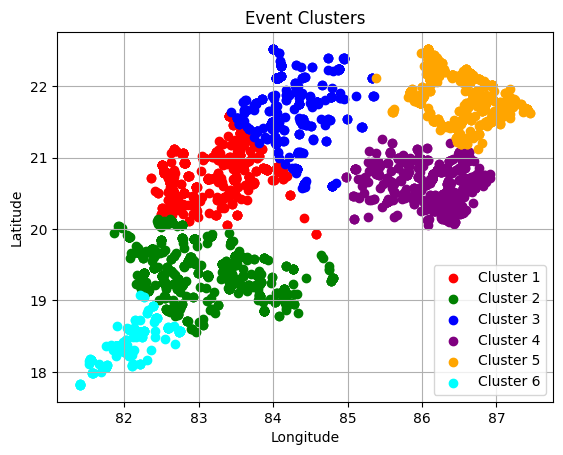

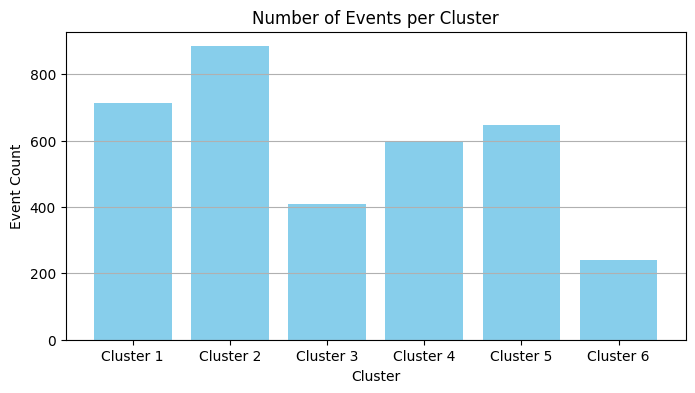

/tmp/ipython-input-242424784.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(durations_per_cluster, labels=[f'C{i+1}' for i in range(len(clusters))])


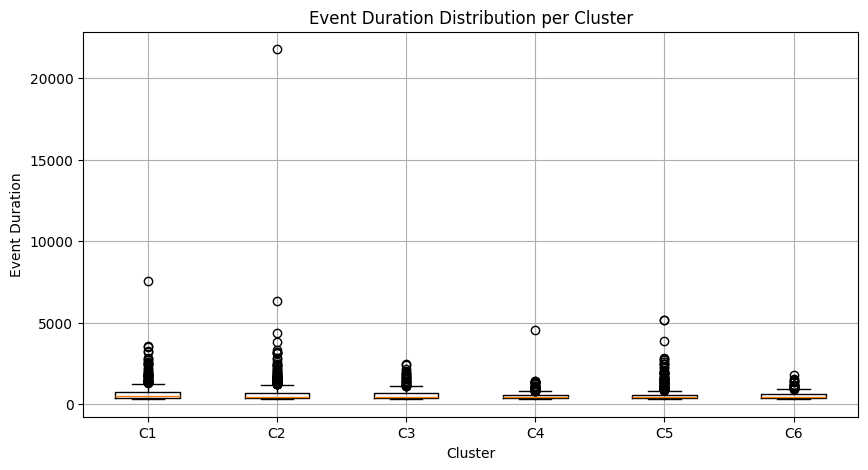


Cluster assignments saved to: clustered_output.csv


In [27]:
# Final Runner
def main():
    events = read_data('data.csv')
    print(f"\nTotal events loaded: {len(events)}")

    print("\nFinding optimal number of clusters using Elbow Method:")
    sse_list = find_optimal_k(events)

    optimal_k = int(input("\nEnter the optimal number of clusters (from SSE elbow): "))
    final_clusters, final_centroids = k_means(events, optimal_k)

    print("\nCluster Statistics:")
    summarize_clusters(final_clusters)

    print_summary_report(final_clusters)
    print_cluster_centroids(final_centroids)

    print("\nPlotting clusters...")
    plot_clusters(final_clusters)
    plot_event_counts(final_clusters)
    plot_duration_boxplot(final_clusters)

    save_cluster_assignments(final_clusters)

if __name__ == "__main__":
    main()